In [1]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2

In [24]:
# # input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

In [3]:
net = models.densenet121(pretrained=True)
finalconv_name = 'features'

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\maddy/.torch\models\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████| 32342954/32342954 [00:03<00:00, 9779996.61it/s]


In [4]:
net.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [5]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

In [6]:
net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [7]:
features_blobs

[]

In [8]:
# get the softmax weight
params = list(net.parameters())
# params
weight_softmax = np.squeeze(params[-2].data.numpy())

In [9]:
params[-2].data.numpy()

array([[  2.24406558e-05,  -1.28876331e-04,   6.71682064e-05, ...,
          8.67323279e-02,  -1.28806368e-01,   1.47461936e-01],
       [ -5.15609236e-06,   6.15610261e-05,   2.70109187e-04, ...,
          1.84427738e-01,  -4.66619991e-02,  -3.02633271e-02],
       [  5.15487773e-05,   9.44278690e-06,   8.84436449e-05, ...,
         -3.06332856e-02,   5.49471341e-02,  -1.21758938e-01],
       ..., 
       [ -2.12445570e-06,   4.87440673e-04,   4.56426933e-05, ...,
          8.92912522e-02,  -6.53944016e-02,  -2.28688512e-02],
       [  4.77776848e-06,   6.72578026e-05,   4.29853331e-04, ...,
         -7.15030683e-03,  -2.63923928e-02,  -2.11334117e-02],
       [  1.89808507e-05,  -1.79753071e-04,   1.64687255e-04, ...,
          1.60952180e-03,   9.63733532e-03,  -4.83125774e-03]], dtype=float32)

In [10]:
weight_softmax.shape

(1000, 1024)

In [11]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [12]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
   normalize
])

In [13]:
import glob

In [14]:
glob.glob('../../data/images/*.png')[0]

'../../data/images\\00013774_026.png'

In [16]:
# response = requests.get(IMG_URL)
img_pil = Image.open(glob.glob('../../data/images/*.png')[29])
# img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

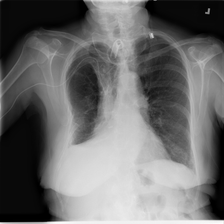

In [17]:
img_pil.thumbnail((224,224),Image.ANTIALIAS)
img_pil

In [18]:
cv2.imread('test.jpg').shape

(1024, 1024, 3)

In [19]:
# assert not features_blobs

In [20]:
img_tensor = preprocess(img_pil)

In [21]:
img_tensor.shape

torch.Size([3, 224, 224])

In [22]:
# img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

In [25]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [26]:
classes[0]

'tench, Tinca tinca'

In [27]:
assert features_blobs

In [28]:
h_x = F.softmax(logit).data.squeeze()
probs, idx = h_x.sort(0, True)

C:\Users\maddy\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [29]:
h_x.sort(0, True)

(
  1.3448e-01
  1.0231e-01
  6.4498e-02
      ⋮     
  4.1630e-08
  2.3021e-08
  2.1994e-08
 [torch.FloatTensor of size 1000], 
  938
  982
  562
  ⋮  
  319
  320
   24
 [torch.LongTensor of size 1000])

In [30]:
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.134 -> cauliflower
0.102 -> groom, bridegroom
0.064 -> fountain
0.062 -> beaker
0.046 -> plastic bag


In [31]:
features_blobs[0].shape

(1, 1024, 7, 7)

In [32]:
idx[2]

562

In [33]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[3]])

In [34]:
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

output CAM.jpg for the top1 prediction: cauliflower


True

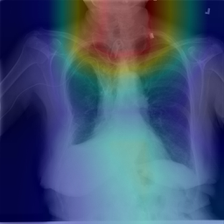

In [35]:
fin_img = Image.open('CAM.jpg')
fin_img.thumbnail((224,224),Image.ANTIALIAS)
fin_img